# Package

In [1]:
#Pytorch
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision import models
from torch.utils.data import DataLoader, Dataset

#For data preprocessing
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import os
import random

#For plotting
import matplotlib.pyplot as plt


#For reproducibility
myseed = 42069  # set a random seed for reproducibility
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# Data Loading

In [65]:
data_path = "./data/"
train_path = os.path.join(data_path, "training_data.csv")
test_path = os.path.join(data_path, "testing_data.csv")

In [66]:
def load_data(train_path, test_path):
    data_train = pd.read_csv(train_path)
    data_test = pd.read_csv(test_path)
    return data_train, data_test

In [67]:
data_train, data_test = load_data(train_path, test_path)
print(data_train.shape)
print(data_test.shape)
print(len(data_train.columns))
print(data_train.columns)

(8784, 11)
(8760, 10)
11
Index(['AMB_TEMP', 'CH4', 'CO', 'NMHC', 'NO', 'NO2', 'NOx', 'PM10', 'PM2.5',
       'RH', 'SO2'],
      dtype='object')


# Data Preprocessing

In [95]:
class EPADataSet(Dataset):
    """Dataset for loading and preprocessing the EPA Weather data
    """
    def __init__(self, path, mode = "train", num_lag = 7, train_valid_ratio = 0.75, scaler = None, train_index = None):
        self.mode = mode
        data = self.load_data(path)
        if mode in ["train", "valid"]:
            self.preprocess_train_valid(data, num_lag, scaler, train_valid_ratio, train_index)
        else:
            self.preprocess_test(data, num_lag, scaler)  
        
        print(f"Finish reading {self.mode} dataset ({len(self.data)} samples, {self.dim} features)")
        #print(self.data)

    def preprocess_train_valid(self, data, num_lag, scaler, train_valid_ratio, train_index):
        #split dataset to X and y
        X = data.loc[:, data.columns != "PM2.5"]
        y = data.loc[:, data.columns == "PM2.5"]
        #get lag variable
        X_with_lag = self.get_lag_variable(X, num_lag)
        X_with_lag.dropna(inplace = True)
        #standardize
        if self.mode == "train":
            self.scaler = StandardScaler().fit(X_with_lag)
            X_with_lag = self.scaler.transform(X_with_lag)
        else: #self.mode == "valid"
            X_with_lag = scaler.transform(X_with_lag)

        #train valid split
        random.seed(5)
        data_len = len(X_with_lag)
        if self.mode == "train":
            train_len = round(train_valid_ratio * data_len)
            index = random.sample(range(data_len), train_len)
            self.train_index = index
        else: 
            index = [i for i in range(data_len) if i not in train_index]

        X_split = X_with_lag[index]
        self.dim = X_split.shape[1]
        self.data = torch.FloatTensor(X_split)
        self.target = torch.FloatTensor(np.array(y))

    def preprocess_test(self, data, num_lag, scaler):
        data_with_lag = self.get_lag_variable(data, num_lag)
        data_with_lag = scaler.transform(data_with_lag)
        self.dim = data_with_lag.shape[1]
        self.data = torch.FloatTensor(data_with_lag)
        
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if self.mode in ["train", "valid"]:
            return self.data[index], self.target[index]
        else:
            return self.data[index]

    def load_data(self, path):
        data = pd.read_csv(path)
        return data

    def get_lag_variable(self, data: pd.DataFrame, num_lag: int):
        #start from 0
        data_ = data.copy()
        for idx in range(num_lag):
            #start from 1
            time = idx + 1
            lag_data = data.shift(time)
            lag_data.columns = [col + "_" + str(-time) for col in data.columns]
            data_ = pd.concat([data_, lag_data], axis = 1)
        #fill testing set nan with "mean"
        if self.mode == "test":
            data_.fillna(data_.mean(), inplace = True)
        return data_

In [90]:
def prep_dataloader(path, mode, batch_size, num_lag, train_valid_ratio, scaler = None, train_index = None, n_jobs=0):
    """Generates a dataset, then is put into a dataloader. 
    """
    dataset = EPADataSet(path, mode, num_lag, train_valid_ratio, scaler, train_index)
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == "train"), drop_last=False,
        num_workers=n_jobs, pin_memory=True)
    if mode == "train":
        scaler = dataset.scaler
        train_index = dataset.train_index     
    return dataloader, scaler, train_index

In [91]:
preprocess_params = {
    "num_lag": 7,
    "train_valid_ratio": 0.75,
    "batch_size": 256
}

In [92]:
data_path = "./data/"
train_path = os.path.join(data_path, "training_data.csv")
test_path = os.path.join(data_path, "testing_data.csv")

In [96]:
train_set, train_scaler, train_index = prep_dataloader(
    train_path, "train", preprocess_params["batch_size"], preprocess_params["num_lag"],
    preprocess_params["train_valid_ratio"])
valid_set, _, _ = prep_dataloader(
    train_path, "valid", preprocess_params["batch_size"], preprocess_params["num_lag"],
    preprocess_params["train_valid_ratio"], train_scaler, train_index)
test_set, _, _ = prep_dataloader(
    test_path, "test", preprocess_params["batch_size"], preprocess_params["num_lag"],
    preprocess_params["train_valid_ratio"], train_scaler, train_index)

Finish reading train dataset (6583 samples, 80 features)
Finish reading valid dataset (2194 samples, 80 features)
Finish reading test dataset (8760 samples, 80 features)


In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

# Modeling

In [ ]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        # TODO: you may implement L1/L2 regularization here
        return self.criterion(pred, target)

# EDA

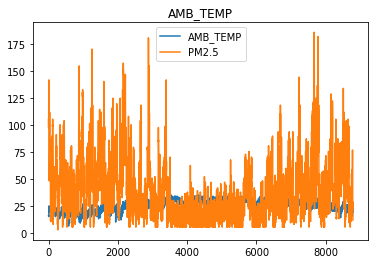

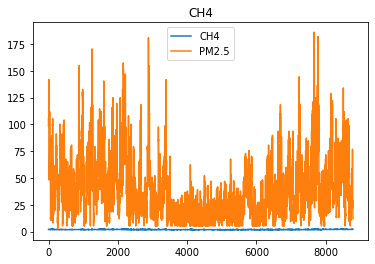

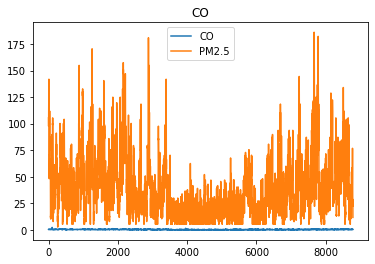

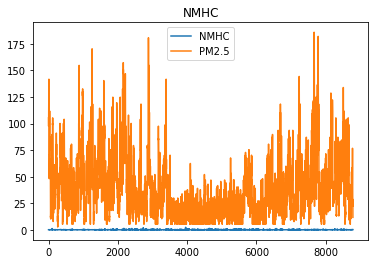

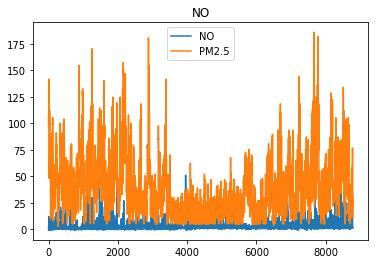

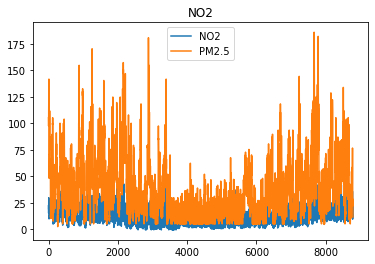

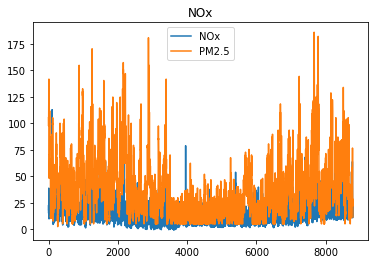

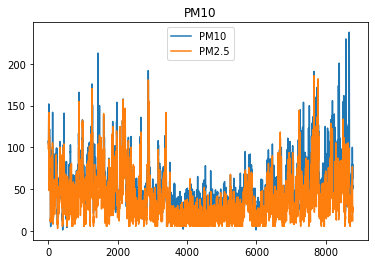

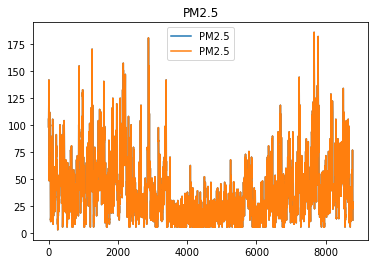

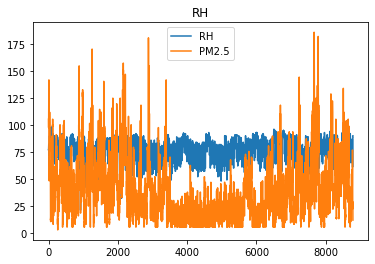

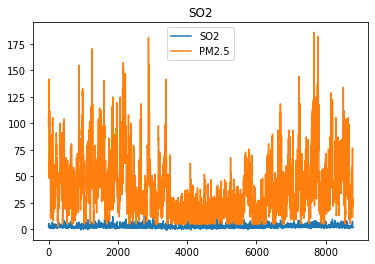

In [71]:
for col in data_train.columns:
    plt.plot(data_train[col])
    plt.plot(data_train["PM2.5"])
    plt.legend([col, "PM2.5"])
    plt.title(col)
    plt.show()

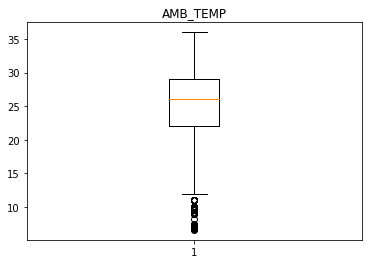

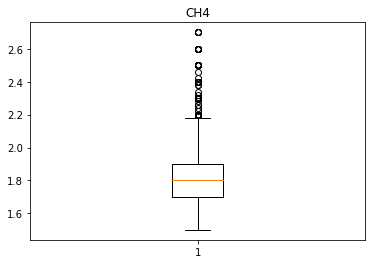

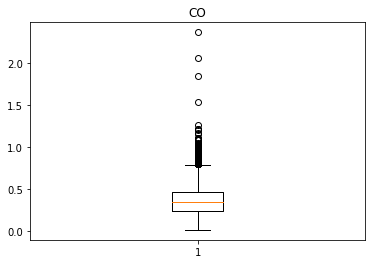

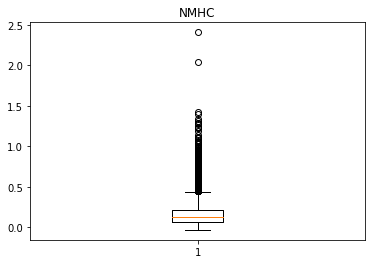

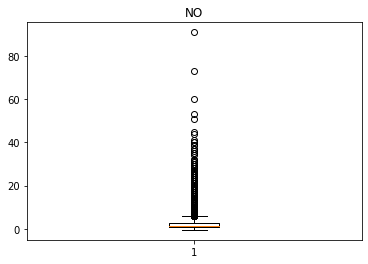

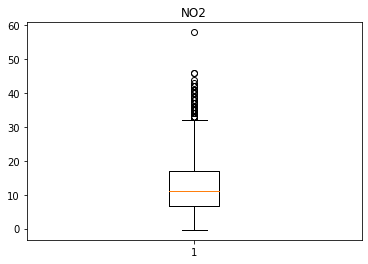

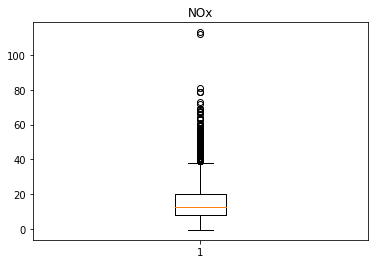

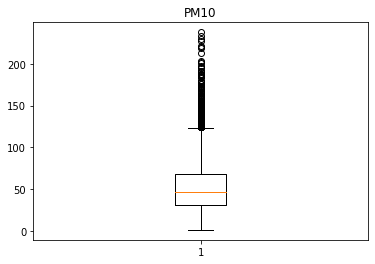

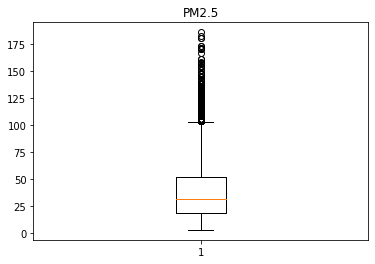

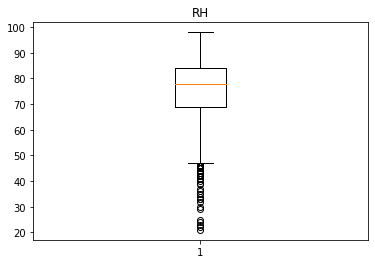

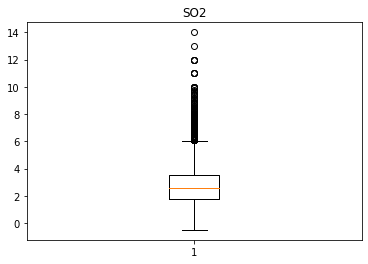

In [15]:
for col in data_train.columns:
    plt.boxplot(data_train[col])
    plt.title(col)
    plt.show()

In [68]:
data_test

,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,PM10,RH,SO2
0,19.0,2.1,0.40,0.19,1.8,20.0,22.0,57.0,91.0,2.1
1,18.0,2.2,0.46,0.18,3.9,19.0,23.0,65.0,92.0,2.6
2,18.0,2.3,0.46,0.17,5.3,19.0,25.0,61.0,92.0,2.6
3,18.0,2.3,0.46,0.19,14.0,22.0,37.0,58.0,93.0,2.5
4,18.0,2.2,0.37,0.16,4.1,17.0,21.0,41.0,93.0,2.0
...,...,...,...,...,...,...,...,...,...,...
8755,17.0,2.2,0.85,0.17,0.9,16.0,17.0,177.0,69.0,2.7
8756,17.0,2.2,0.82,0.17,0.9,18.0,18.0,143.0,70.0,2.3
8757,17.0,2.1,0.78,0.16,1.1,15.0,17.0,110.0,72.0,2.3
8758,16.0,2.1,0.73,0.14,1.2,17.0,18.0,96.0,73.0,2.4
